### 다중 분류 <hr>
- 데이터셋 : scikit-learn Fashion MNIST
- 데이터수 : 학습용 60000, 테스틍용 10000
- 피쳐갯수 : 28 X 28 흑백 이미지로 784
- 타겟갯수 : 티셔츠/상의, 바지, 풀오버, 드레스, 코트, 샌들, 셔츠, 운동화, 가방, 발목 부츠 등 10가지

[1] 모듈 로딩 및 데이터 준비 <hr>

In [4]:
### ===> 모듈 로딩
from sklearn.datasets import fetch_openml 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import torch
import torch.nn.functional as F 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim 
import torchmetrics.functional as metrics
import numpy as np

In [5]:
### ===> 데이터 로딩 
db_name = 'Fashion-MNIST'

# as_frame=False : ndarray 형식으로 반환
fashion_data = fetch_openml(name=db_name, parser='auto', as_frame=False)

In [6]:
### ===> 데이터 확인
print(f'data   => {fashion_data["data"].dtype}, {fashion_data["data"].shape}')
print(f'target => {fashion_data["target"].dtype}, {fashion_data["target"].shape}')
print(f'feature_names => {fashion_data["feature_names"]}\ntarget_names => {fashion_data["target_names"]}')
print(f'categories => {fashion_data["categories"]}')

data   => int64, (70000, 784)
target => object, (70000,)
feature_names => ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85',

[2] 데이터 전처리 - 피쳐와 타겟 분리, 정규화 <hr>

In [7]:
### ===> 피쳐와 타겟 분리
# sklearn dataset 에서 이미 처리 해둠
feature=fashion_data['data']
target=fashion_data['target']

print(f'feature => {type(feature)}, {feature.shape}')
print(f'feature raw data =>\n{feature[:1]}\n')

print(f'target  => {type(target)},{target.shape}')
print(f'target raw data  => {target[:1]}')

feature => <class 'numpy.ndarray'>, (70000, 784)
feature raw data =>
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   1   0   0  13  73   0   0   1   4   0   0   0
    0   1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   3   0
   36 136 127  62  54   0   0   0   1   3   4   0   0   3   0   0   0   0
    0   0   0   0   0   0   0   0   6   0 102 204 176 134 144 123  23   0
    0   0   0  12  10   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 155 236 207 178 107 156 161 109  64  23  77 130  72  15   0   0
    0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216 216 163
  127 121 122 146 141  88 172  66   0   0  

In [8]:
### ===> 정규화 : 피쳐
# 이미지 데이터 값 0 ~ 255b
norm_feature =feature/255.

print(f'norm_feature =>\n{norm_feature[:2]}')
print(f'norm_feature min => {norm_feature.min()}   max => { norm_feature.max()}')

norm_feature =>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
norm_feature min => 0.0   max => 1.0


In [9]:
### ===> 정규화 : 타겟
# # 타겟 분류 클래스 : '0' ~ '9'  ==> 0 ~ 9 정수 변환
norm_target=target.astype(int)
print(f'norm_target : {norm_target.dtype} {np.unique(norm_target).size}개')


norm_target : int32 10개


In [10]:
print(f'norm_target => {norm_target.shape}, {norm_target.ndim}D\n{norm_target[:5]}')

norm_target => (70000,), 1D
[9 0 0 3 0]


[3] 학습 데이터 셋 준비 - 훈련용, 검증용, 테스트용 데이터 셋 <hr>

- [3-1] 사용자 정의 데이터 셋 및 전체 데이터셋 준비

In [11]:
### 사용자정의 DataSet 클래스 
# - 데이터의 Tensor 변환 
class DLDataset(Dataset):
    
    # 초기화 함수 콜백함수(callback funcaion)
    def __init__(self, x_data, y_data):
        super().__init__()
        # ndarray ==> tensor
        self.feature=torch.FloatTensor(x_data)
        self.target=torch.LongTensor(y_data)
        
        
    # 데이터셋의 갯수 체크 함수 콜백함수(callback funcaion)
    def __len__(self):
        return self.target.shape[0]
    
    
    # 특정 인덱스 데이터+라벨 반환 콜백함수(callback funcaion)
    def __getitem__(self, index):
        return self.feature[index], self.target[index]

In [12]:
### 전체 데이터셋 생성
##  DataSet 생성
all_dataset = DLDataset(norm_feature, norm_target)

print(f'[all dataset] feature : {all_dataset.feature.shape},   target : {all_dataset.target.shape}')

[all dataset] feature : torch.Size([70000, 784]),   target : torch.Size([70000])


- [3-2] 학습용, 검증용, 테스트용 데이터셋 분리 

In [13]:
# 랜덤 고정 설정
seed_gen=torch.Generator().manual_seed(42)

TR_SIZE, VA_SIZE, TE_SIZE = 0.7, 0.1, 0.2

trainDS, validDS, testDS = random_split(all_dataset, 
                                  [TR_SIZE, VA_SIZE, TE_SIZE], 
                                  generator=seed_gen)

print(f"Train dataset length    : {len(trainDS)}개")
print(f"Validation dataset      : {len(validDS)}개")
print(f"Test dataset            : {len(testDS)}개")

Train dataset length    : 49000개
Validation dataset      : 7000개
Test dataset            : 14000개


[4] 데이터 로더 생성 <hr>

In [14]:
BATCH_SIZE = 50

TRAIN_DL = DataLoader(trainDS, batch_size=BATCH_SIZE)
VALID_DL = DataLoader(validDS, batch_size=BATCH_SIZE)
TEST_DL = DataLoader(testDS,   batch_size=BATCH_SIZE)

[5] 모델 준비 : 입력층 입력 수, 출력층 출력 수 <hr>

In [15]:
### ===> 다중 분류 모델
### ===> 입력층 피쳐 수  : 28 * 28
### ===> 출력층 피쳐 수  : 10 (0 ~ 9)
class MNISTModel(nn.Module):
    
    # 모델 구성 요소 초기화 
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layer1=nn.Linear(in_dim, 200)
        self.layer2=nn.Linear(200, 100)
        self.layer3=nn.Linear(100, 50)
        self.layer4=nn.Linear(50, out_dim)
        self.relu=nn.ReLU()
        
    def forward(self, x):
        y=self.layer1(x)
        y=self.relu(y)
        y=self.layer2(y)
        y=self.relu(y)
        y=self.layer3(y)
        y=self.relu(y)
        y=self.layer4(y)
        return y
        

In [61]:
### ===> 다중 분류 모델
### ===> 입력층 피쳐 수 : 28 * 28
### ===> 은닉층 개수, 피쳐 수 : 동적
### ===> 출력층 피쳐 수 : 10 (0 ~ 9)
class MNISTModel2(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.input_layer = nn.Linear(in_dim, int(in_dim / 2))
        self.hidden_layer = []
        percep = int(in_dim / 2)
        while percep > 50:
            self.hidden_layer.append(nn.Linear(percep, int(percep / 2)))
            percep = int(percep / 2)
        self.output_layer = nn.Linear(percep, out_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        for hl in self.hidden_layer:
            x = hl(x)
            x = self.relu(x)
        x = self.output_layer(x)
        return x

[6] 학습 관련 함수 정의 <hr>

- [6-1] 학습 진행 준비 :  모델, 최적화, 학습횟수 

In [41]:
## 학습 중 모델 저장 관련 변수
import os

dir = '../data/model1'
filename = dir + '/best_model.pth'

if not os.path.exists(dir):
    os.mkdir(dir)   # 하위 폴더만 생성, 즉 data 폴더는 이미 존재해야 함
    # os.makedirs(dir)    # 존재하지 않는 상위 폴더부터 생성

In [62]:
# 실행 디바이스 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# 입출력 피쳐
IN_DIM , OUT_DIM = norm_feature.shape[1], np.unique(norm_target).size

# 모델 인스턴스 
MODEL = MNISTModel2(IN_DIM, OUT_DIM).to(DEVICE)

# 최적화 인스턴스 생성
OPTIMIZER = optim.SGD(MODEL.parameters())

#  손실 함수
LOSS_FN = nn.CrossEntropyLoss().to(DEVICE)

# 학습 횟수 설정
EPOCHS=10

# 분류 개수
CLASSES = 10

In [18]:
### ===> 학습 진행함수 
def training(epoch, model, optimizer, dataLoader, device, loss_fn, classes):
    # 학습모드 => 정규화, 경사하강법, 드랍아웃 등의 기능 활성화 
    model.train()
    
    # 배치크기 만큼 학습 진행 및 저장
    train_report=[[], [], []]
    for idx, (feature, target)  in enumerate(dataLoader):
        # 배치크기만큼의 학습 데이터 준비
        feature, target = feature.to(device), target.to(device)
        
        # 학습
        pre_traget = model(feature)
        
        # 손실계산
        loss = loss_fn(pre_traget, target)
        train_report[0].append(loss)
        
        # 성능 평가
        acc = metrics.accuracy(pre_traget, target, task='multiclass', num_classes=classes)
        train_report[1].append(acc)
        
        f1 = metrics.f1_score(pre_traget, target, task='multiclass', num_classes=classes)
        train_report[2].append(f1)
        
        # W,b업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if not idx%50: print('.', end='')
    
    # 에포크 단위 학습 진행 메시지 출력
    loss_score = (sum(train_report[0])/BATCH_SIZE).item()
    acc_score = (sum(train_report[1])/BATCH_SIZE).item()
    f1_score = (sum(train_report[2])/BATCH_SIZE).item() 
    print(f'\n[{epoch} Train ] Loss ==> {loss_score:.3f} Acc ==> {acc_score:.3f} F1 ==> {f1_score:.3f}')
    
    return loss_score, acc_score, f1_score

In [19]:
### ===> 검증 및 테스트 진행함수 
def testing(epoch, model, dataLoader, device, loss_fn, classes, kind='valid'):
    # 학습모드 => 정규화, 경사하강법, 드랍아웃 등의 기능 활성화 
    model.eval()
        
    with torch.no_grad():
        # 배치크기 만큼 학습 진행 및 저장
        test_report=[[], [], []]
        # dataLoader = VALID_DL if kind=='valid' else TEST_DL
        for idx, (feature, target)  in enumerate(dataLoader):
            # 배치크기만큼의 학습 데이터 준비
            feature, target = feature.to(device), target.to(device)

            # 학습
            pre_traget = model(feature)

            # 손실계산
            loss = loss_fn(pre_traget, target)
            test_report[0].append(loss)
            
            # 성능 평가 
            acc = metrics.accuracy(pre_traget, target, task='multiclass', num_classes=classes)
            test_report[1].append(acc)
            
            f1 = metrics.f1_score(pre_traget, target, task='multiclass', num_classes=classes)
            test_report[2].append(f1)
            
            #if not idx%50: print('.', end='')

    testing_type = 'Valid' if kind == 'valid' else 'Test'
        
    # 에포크 단위 학습 진행 메시지 출력
    loss_score = (sum(test_report[0])/BATCH_SIZE).item()
    acc_score = (sum(test_report[1])/BATCH_SIZE).item()
    f1_score = (sum(test_report[2])/BATCH_SIZE).item() 
    print(f'[{epoch} {testing_type} ] Loss ==> {loss_score:.3f} Acc ==> {acc_score:.3f} F1 ==> {f1_score:.3f}\n')
    
    return loss_score, acc_score, f1_score

[7] 학습 : 학습 진행 준비, 학습 진행 <hr>

- 학습 진행

In [63]:
# 학습 및 검증 데이터별 성능지표값
train_ = {'loss':[], 'acc':[], 'f1':[]}
val_ = {'loss':[], 'acc':[], 'f1':[]}

# 모델 저장 관련 변수
pred_va_score = 100

# 학습 진행
for epo in range(EPOCHS):
    print(f"[Epoch {epo+1}/{EPOCHS}] ", end='')
    tr_score=training(epo, MODEL,OPTIMIZER, TRAIN_DL, DEVICE, LOSS_FN, OUT_DIM)
    va_score=testing(epo, MODEL, VALID_DL, DEVICE, LOSS_FN, OUT_DIM)
    
    # 검증 데이터 기준 학습된 모델 저장 => Loss가 이전보다 작을 경우 저장 / Acc 또는 F1이면 이전보다 큰 경우 저장
    if pred_va_score > va_score[0]:
        torch.save(MODEL, filename)
        print('SAVED')
    
    for idx, key in enumerate(train_):
        train_[key].append(tr_score[idx])
        val_[key].append(va_score[idx])

print("Done!")

[Epoch 1/10] ....................
[0 Train ] Loss ==> 45.202 Acc ==> 1.941 F1 ==> 1.941
[0 Valid ] Loss ==> 6.453 Acc ==> 0.286 F1 ==> 0.286

SAVED
[Epoch 2/10] ....................
[1 Train ] Loss ==> 45.156 Acc ==> 1.941 F1 ==> 1.941
[1 Valid ] Loss ==> 6.447 Acc ==> 0.286 F1 ==> 0.286

SAVED
[Epoch 3/10] ....................
[2 Train ] Loss ==> 45.113 Acc ==> 1.941 F1 ==> 1.941
[2 Valid ] Loss ==> 6.441 Acc ==> 0.286 F1 ==> 0.286

SAVED
[Epoch 4/10] ....................
[3 Train ] Loss ==> 45.071 Acc ==> 1.942 F1 ==> 1.942
[3 Valid ] Loss ==> 6.435 Acc ==> 0.286 F1 ==> 0.286

SAVED
[Epoch 5/10] ....................
[4 Train ] Loss ==> 45.028 Acc ==> 2.027 F1 ==> 2.027
[4 Valid ] Loss ==> 6.429 Acc ==> 0.328 F1 ==> 0.328

SAVED
[Epoch 6/10] ....................
[5 Train ] Loss ==> 44.984 Acc ==> 2.639 F1 ==> 2.639
[5 Valid ] Loss ==> 6.423 Acc ==> 0.449 F1 ==> 0.449

SAVED
[Epoch 7/10] ....................
[6 Train ] Loss ==> 44.939 Acc ==> 3.309 F1 ==> 3.309
[6 Valid ] Loss ==> 6.41

- [7-2] 학습 후 평가 : Loss, Acc, F1 <hr>

In [21]:
for idx, key in enumerate(train_):
    print(f'{key} ', train_[key])

loss  [45.07805633544922, 44.8035774230957, 44.4404296875, 43.85905838012695, 42.745182037353516, 40.34749221801758, 35.68416976928711, 30.195110321044922, 25.720102310180664, 22.605541229248047, 20.456113815307617, 18.91295051574707, 17.777446746826172, 16.91620635986328, 16.24665069580078, 15.704113006591797, 15.242199897766113, 14.834637641906738, 14.46688461303711, 14.130301475524902, 13.81915283203125, 13.529720306396484, 13.26076889038086, 13.012271881103516, 12.784671783447266, 12.57711410522461, 12.38833236694336, 12.216675758361816, 12.060211181640625, 11.916983604431152, 11.785096168518066, 11.662723541259766, 11.548659324645996, 11.44186019897461, 11.341327667236328, 11.246194839477539, 11.15595817565918, 11.069870948791504, 10.987482070922852, 10.908283233642578, 10.83187484741211, 10.757965087890625, 10.686352729797363, 10.617022514343262, 10.549827575683594, 10.484387397766113, 10.420565605163574, 10.358250617980957, 10.297306060791016, 10.237593650817871, 10.178993225097

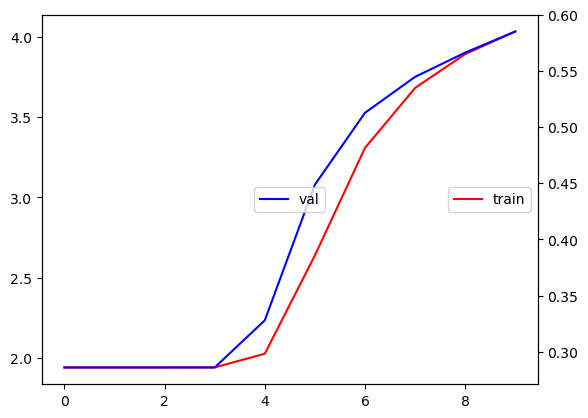

In [64]:
### Loss와 Acc F1 시각화
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(train_['acc'], label='train', color='red')

ax2 = ax1.twinx()
ax2.plot(val_['acc'], label='val', color='blue')

# ax3 = ax1.twinx()
# ax3.plot(train_['f1'], label='f1', color='orange')
ax1.legend(loc='center right')
ax2.legend(loc='center')
plt.show()

In [27]:
train_['f1'] == train_['acc']

True

[6] 테스트 <hr>